In [81]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam # the non-legacy version runs slowly on Mac
import keras_tuner as kt
from keras.utils import plot_model

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.compose import make_column_transformer
from NAM_models import ActivationLayer, FeatureNN, NAM

#-------------------------- import data --------------------------
'''we use the popular French Motor TPL insurance claim data '''
freq = pd.read_csv("data/freMTPL2freq.csv")
sev = pd.read_csv("data/freMTPL2sev.csv")

In [82]:
############################ 1. PREPROCESSING ############################

random.seed(2000)

#-------------------------- merge/filter claim data --------------------------
# complete claim severity data
claimsev = sev.merge(freq, on = 'IDpol', how = 'left')
claimsev = claimsev.drop(columns = ['ClaimNb', 'Exposure'])

# drop ID
claimfreq = freq.drop(columns = "IDpol")


#-------------------------- subsample and split --------------------------
# train-test-split
claimfreq['ClaimNb_Cat'] = np.where(claimfreq['ClaimNb'] == 0, 0, 1) # for stratified splitting
X_train, X_test, y_train, y_test = train_test_split(
    claimfreq.drop(["ClaimNb", "ClaimNb_Cat"], axis = 1), 
    claimfreq["ClaimNb"], 
    stratify = claimfreq["ClaimNb_Cat"], 
    random_state = 2000)
claimfreq = claimfreq.drop("ClaimNb_Cat", axis = 1)

In [83]:
#-------------------------- feature transformation --------------------------

# define transformer
ct = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OrdinalEncoder(), ["Area", "VehGas"]),
    (OneHotEncoder(), ["VehBrand", "Region"]),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)


# fit & transform
train = ct.fit_transform(X_train).toarray()
test = ct.transform(X_test).toarray()
feature_names = ct.get_feature_names_out()  # get the columns' names


# feature summary
feature_expansion = {} # number of columns for each feature after transformation
for original_feature in X_train.columns:
    # For each original feature, count how many transformed feature names start with it
    count = sum(fn.startswith(original_feature) for fn in feature_names)
    feature_expansion[original_feature] = count
print(feature_expansion)

{'Exposure': 1, 'VehPower': 1, 'VehAge': 1, 'DrivAge': 1, 'BonusMalus': 1, 'VehBrand': 11, 'VehGas': 1, 'Area': 1, 'Density': 1, 'Region': 21}


In [84]:
############################ 2. NAM ############################

#-------------------------- define functions to create NAM and subnets --------------------------
'''create subnetwork for each feature/group of features'''
def create_subnet(input_shape):
    model = Sequential([
        Dense(64, activation = 'leaky_relu'),
        Dense(32, activation = 'leaky_relu'),
        Dense(1, activation = 'softplus')  # output layer for the subnet, assuming a scalar output
    ])
    return model


'''create NAM'''
def create_nam_model(feature_expansion):
    inputs = [] # store the input layer of each subnet 
    sub_outputs = [] # store the output of each subnetwork
    for name, num_columns in feature_expansion.items():
        input_layer = Input(name = name, shape = (num_columns,))
        inputs.append(input_layer)
        
        if name == "Exposure":
            # assume the first input is the exposure, we directly use it without a subnet
            exposure_input = input_layer
        else:
            # create subnet for each feature/group of features
            subnet = create_subnet(num_columns)
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)
    
    # concatenate the outputs of the subnets and sum them
    sum_of_subs = Add()(sub_outputs)
    
    # multiply the exposure input by the sum of subnets' outputs
    final_output = Multiply()([exposure_input, sum_of_subs])
    
    # final model
    model = Model(inputs = inputs, outputs = final_output)
    return model

In [ ]:
############################ 2. NAM ############################

#-------------------------- define functions to create NAM and subnets --------------------------


In [85]:
# -------------------------- fit a NAM to training data --------------------------

model_NAM = create_nam_model(feature_expansion)  # create NAM
model_NAM.compile(
    optimizer="adam", loss="poisson", metrics=["mean_squared_error", "poisson"]
)
es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

# training data need to be split into different arrays, each correponds to input for a particular subnet
start = 0
X_train_split = []
for size in feature_expansion.values():
    end = start + size
    X_train_split.append(train[:, start:end])
    start = end

# fit the model
model_NAM.fit(
    X_train_split,
    y_train,
    epochs = 50,
    batch_size = 128,
    callbacks = [es],
    validation_split = 0.2,
)

Epoch 1/50
3179/3179 [==============================] - 8s 2ms/step - loss: 0.2459 - mean_squared_error: 0.1769 - poisson: 0.2459 - val_loss: 0.2105 - val_mean_squared_error: 0.0559 - val_poisson: 0.2105
Epoch 2/50
3179/3179 [==============================] - 8s 2ms/step - loss: 0.2088 - mean_squared_error: 0.0577 - poisson: 0.2088 - val_loss: 0.2084 - val_mean_squared_error: 0.0558 - val_poisson: 0.2084
Epoch 3/50
3179/3179 [==============================] - 8s 2ms/step - loss: 0.2077 - mean_squared_error: 0.0576 - poisson: 0.2077 - val_loss: 0.2073 - val_mean_squared_error: 0.0556 - val_poisson: 0.2073
Epoch 4/50
3179/3179 [==============================] - 8s 2ms/step - loss: 0.2068 - mean_squared_error: 0.0576 - poisson: 0.2068 - val_loss: 0.2063 - val_mean_squared_error: 0.0557 - val_poisson: 0.2063
Epoch 5/50
3179/3179 [==============================] - 8s 2ms/step - loss: 0.2062 - mean_squared_error: 0.0575 - poisson: 0.2062 - val_loss: 0.2062 - val_mean_squared_error: 0.0559 - 

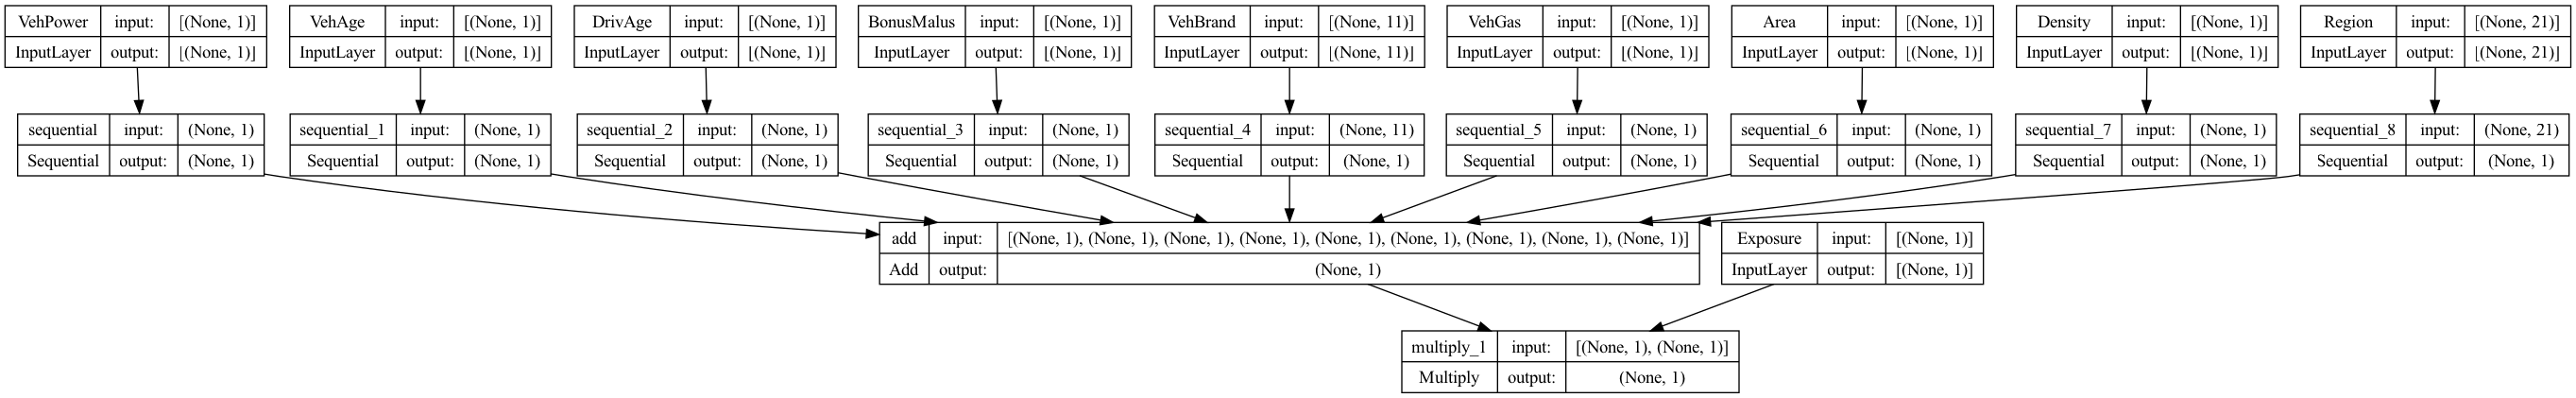

In [86]:
#-------------------------- plot model --------------------------
plot_model(model_NAM, show_layer_names = True, show_shapes = True)

In [87]:
#-------------------------- evaluate on testing data --------------------------

# split testing data into different sets
start = 0
X_test_split = []
for size in feature_expansion.values():
    end = start + size
    X_test_split.append(test[:, start:end])
    start = end

# evaluation
nam_poisson_loss, nam_mse, _ = model_NAM.evaluate(X_test_split, y_test)
print(f"NAM test set metrics ~ Poisson loss: {nam_poisson_loss:.4f}, MSE: {nam_mse:.4f}")

5297/5297 [==============================] - 3s 635us/step - loss: 0.2055 - mean_squared_error: 0.0561 - poisson: 0.2055
NAM test set metrics ~ Poisson loss: 0.2055, MSE: 0.0561


In [88]:
############################ 3. GLM ############################

#-------------------------- preprocessing --------------------------
'''we want to use dummy encoding for VehBrand and Region so 2 columns need
to be removed from both training and test data. These 2 columns are the reference
levels for VehBrand and Region. Choose B12 for VehBrand and Centre for Region.'''

# separate the offset term (or exposure)
offset_train = train[:, 0]
offset_test = test[:, 0]

# index for reference level in feature_names
ref_index = [np.where(feature_names == "VehBrand_B12")[0][0],
             np.where(feature_names == "Region_Centre")[0][0]]
ref_index.append(0) # Exposure

# remove reference levels
train_dummy = np.delete(train, ref_index, axis = 1)
test_dummy = np.delete(test, ref_index, axis = 1)
feature_dummy = [feature for i, feature in enumerate(feature_names) if i not in ref_index]

# add a constant to the model (intercept)
train_dummy = sm.add_constant(train_dummy)
test_dummy = sm.add_constant(test_dummy)

In [89]:
train_dummy

array([[ 1.        ,  2.        ,  0.        , ..., -0.17701726,
        -0.62489265, -0.3504369 ],
       [ 1.        ,  4.        ,  0.        , ..., -0.6013795 ,
         0.52641895,  0.2391318 ],
       [ 1.        ,  0.        ,  0.        , ...,  0.24734498,
        -0.62489265, -0.44413983],
       ...,
       [ 1.        ,  2.        ,  1.        , ...,  0.53025314,
        -0.62489265, -0.35955394],
       [ 1.        ,  2.        ,  1.        , ...,  0.24734498,
        -0.62489265, -0.42134722],
       [ 1.        ,  2.        ,  0.        , ..., -0.9550147 ,
         0.78226597, -0.38943758]])

In [90]:
#-------------------------- fit a GLM model --------------------------
model_GLM = sm.GLM(y_train, train_dummy, family = sm.families.Poisson(), offset = offset_train)
results = model_GLM.fit()
# results.summary()

In [91]:
#-------------------------- evaluation --------------------------
GLM_pred = results.predict(test_dummy, offset = offset_test)
GLM_mse = mse(y_test, GLM_pred)
print(GLM_mse)

0.05597262732209103


In [92]:
# Calculate the Poisson loss for the GLM model which Keras uses
glm_poisson_loss = keras.losses.Poisson()(y_test, GLM_pred).numpy()
glm_poisson_loss

0.20340569755381815

In [93]:
############################ 4. NEURAL NETWORKS ############################

#-------------------------- preprocessing --------------------------
ct_NN = make_column_transformer(
    ("passthrough", ["Exposure"]),
    (OrdinalEncoder(), ["Area", "VehGas", "VehBrand", "Region"]),
    remainder = StandardScaler(),
    verbose_feature_names_out = False)


# transform the data
train_NN = ct_NN.fit_transform(X_train)
test_NN = ct_NN.transform(X_test)
feature_names_NN = ct_NN.get_feature_names_out()  # get the columns' names


# separate exposure column
exposure_index = np.where(feature_names_NN == "Exposure")[0][0] # index of the Exposure column
train_exposure = train_NN[:,exposure_index]
test_exposure = test_NN[:,exposure_index]


# separate multi-level categorical columns
categorical_var = ["Area", "VehBrand", "Region"]
train_cat = []
test_cat = []
cat_index = []
for i in range(len(categorical_var)):
    index = np.where(feature_names_NN == categorical_var[i])[0][0]
    train_cat.append(train_NN[:,index])
    test_cat.append(test_NN[:,index])
    cat_index.append(index)

                    
# drop exposure and nominal categorical columns
train_others = np.delete(train_NN, [exposure_index] + cat_index, axis = 1)
test_others = np.delete(test_NN, [exposure_index] + cat_index, axis = 1)

In [110]:
#-------------------------- define model architecture --------------------------

'''Define model architecture'''
def build_model(hp):
    # input & embedding layers - use entity embedding for categorical variables
    exposure = Input(shape=(1,), name = "exposure") # exposure

    cat_inputs = [] # input layers for nominal categorical features
    embedding_layers = [] # embedding layers
    embedding_dim_low_dim = hp.Int('embedding_dim_low_dim', 2, 4, step = 1)
    embedding_dim_high_dim = hp.Int('embedding_dim_high_dim', 5, 10, step = 2)
    for cat_column in categorical_var:

        # input layers
        cat_input = Input(shape = (1,), name = f"input_{cat_column}")  # assuming categorical vars are single integers
        cat_inputs.append(cat_input)

        # embedding layers
        if cat_column == "Region":
            embed_layer = Embedding(input_dim = claimfreq[cat_column].nunique(), output_dim = embedding_dim_high_dim, name = f"embed_{cat_column}")(cat_input)
            embed_layer_reshape = Reshape(target_shape = (embedding_dim_high_dim,), name = f"reshape_{cat_column}")(embed_layer)
        else:
            embed_layer = Embedding(input_dim = claimfreq[cat_column].nunique(), output_dim = embedding_dim_low_dim, name = f"embed_{cat_column}")(cat_input)
            embed_layer_reshape = Reshape(target_shape = (embedding_dim_low_dim,), name = f"reshape_{cat_column}")(embed_layer)
        embedding_layers.append(embed_layer_reshape)
        
    other_inputs = Input(shape = train_others.shape[1:])
    inputs = Concatenate(name = "combined_input")(embedding_layers + [other_inputs])

    # dense layers
    x = inputs
    activation = hp.Choice('activation', ['leaky_relu', 'relu', 'elu', 'selu'])
    for i in range(hp.Int('num_dense_layers', 2, 6)):
        num_units = hp.Int(f'num_units_{i}', 32, 128, step = 32)
        x = Dense(units = num_units, activation = activation)(x)
        # x = Dropout(rate = hp.Float(f'dropout_{i}', min_value = 0.0, max_value = 0.3, step = 0.1))(x)
    lambda_ = Dense(1, "exponential")(x)

    # final output
    out = Multiply()([lambda_, exposure])
    model = Model([exposure] + cat_inputs + [other_inputs], out)

    # optimizer
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
    optimizer = Adam(learning_rate = lr)
    
    # build model
    model.compile(optimizer = "adam",
              loss = "poisson", 
              metrics = ['mean_squared_error', 'poisson'])
    
    return model

In [112]:
#-------------------------- tune and fit fit a deep NN --------------------------
# tuner
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 5,  # Increased trials due to additional hyperparameters
    directory = "hyperparameter_tuning",
    seed = 2000 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 10, restore_best_weights = True, verbose = 0)

# search for the best model
tuner.search([train_exposure, train_cat, train_others], y_train,
            epochs = 100,  
            batch_size = 256, 
            validation_split = 0.2,
            callbacks = [es])

# get the best model
model_NN = tuner.get_best_models()[0]
tuner.results_summary(1)

Trial 5 Complete [00h 01m 08s]
val_loss: 0.20234927535057068

Best val_loss So Far: 0.20227180421352386
Total elapsed time: 00h 06m 38s
Results summary
Results in hyperparameter_tuning/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 3 summary
Hyperparameters:
embedding_dim_low_dim: 4
embedding_dim_high_dim: 7
activation: relu
num_dense_layers: 4
num_units_0: 96
num_units_1: 32
learning_rate: 0.00016468966822474475
num_units_2: 32
num_units_3: 32
Score: 0.20227180421352386


In [113]:
#-------------------------- evaluate on test set --------------------------
nn_poisson_loss, nn_mse, _ = model_NN.evaluate([test_exposure, test_cat, test_others], y_test)
print(f"NN test set metrics ~ Poisson loss: {nn_poisson_loss:.4f}, MSE: {nn_mse:.4f}")

5297/5297 [==============================] - 2s 440us/step - loss: 0.2033 - mean_squared_error: 0.0557 - poisson: 0.2033
NN test set metrics ~ Poisson loss: 0.2033, MSE: 0.0557


In [114]:
# Print all the results
print(f"GLM test set metrics \t Poisson loss: {glm_poisson_loss:.4f} \t MSE: {GLM_mse:.4f}")
print(f"NAM test set metrics \t Poisson loss: {nam_poisson_loss:.4f} \t MSE: {nam_mse:.4f}")
print(f"NN test set metrics \t Poisson loss: {nn_poisson_loss:.4f} \t MSE: {nn_mse:.4f}")

GLM test set metrics 	 Poisson loss: 0.2034 	 MSE: 0.0560
NAM test set metrics 	 Poisson loss: 0.2055 	 MSE: 0.0561
NN test set metrics 	 Poisson loss: 0.2033 	 MSE: 0.0557
